# Two‑Stage T5 Summarization Fine‑Tuning (Quick Prototype)
**Goal:** Minimal, easy‑to‑run workflow that
1. Evaluates a pre‑trained FLAN‑T5 on a tiny validation split.
2. Fine‑tunes on CNN/DailyMail (Stage 1) ➜ evaluates.
3. Continues fine‑tuning on your domain dataset (Stage 2) ➜ evaluates.
4. Draws loss curves for both stages.

💡 90 % of each dataset is kept for *validation* so you can run a super‑quick 10 % training pass first.

### 🔧 Install (1 cell)
Quick one‑liner to grab everything.

In [1]:
!pip install --quiet transformers datasets accelerate evaluate rouge-score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packa

### 🚀 Imports & paths

In [2]:
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer)
import evaluate, torch, matplotlib.pyplot as plt, pandas as pd

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ↩️ Adjust these if paths differ
CNN_PATH  = '/kaggle/input/summary-dataset/cnn_dailymail.csv'
DOMAIN_PATH = '/kaggle/input/fine-tune-2-0/mock_1000_balanced_journals.csv'
MODEL_NAME = 'google/flan-t5-small'
OUTPUT_DIR = Path('checkpoints')
OUTPUT_DIR.mkdir(exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(DEVICE)


2025-07-07 11:49:53.240793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751888993.609903      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751888993.725779      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### 📄 Load & tokenize (2 cells)

In [3]:
def prep_dataset(path,
                 source_col='text',   # CNN/DailyMail default
                 target_col='summary',
                 split_ratio=0.1,
                 limit=None):

    data = load_dataset('csv', data_files=path, split='train')
    if limit:
        data = data.select(range(limit))
    data = data.train_test_split(test_size=1 - split_ratio, seed=42)
    def tok(batch):
        model_inputs = tokenizer(batch[source_col],
                                 truncation=True,
                                 padding='max_length',
                                 max_length=512)
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(batch[target_col],
                               truncation=True,
                               padding='max_length',
                               max_length=128)
        model_inputs['labels'] = labels['input_ids']
        return model_inputs

    train_ds = data['train'].map(tok, batched=True,
                                 remove_columns=data['train'].column_names)
    val_ds   = data['test'].map(tok,  batched=True,
                                 remove_columns=data['test'].column_names)
    cols = ['input_ids', 'attention_mask', 'labels']
    train_ds.set_format(type='torch', columns=cols)
    val_ds.set_format(type='torch',   columns=cols)

    return train_ds, val_ds


### 📊 Metrics & baseline evaluation (1 cell)

In [4]:
rouge = evaluate.load('rouge')
bertscore = evaluate.load('bertscore')

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    r = rouge.compute(predictions=preds, references=labels, use_stemmer=True)['rougeL']
    b = bertscore.compute(predictions=preds, references=labels, model_type='roberta-large')['f1']
    return {'rougeL': r, 'bertscore_f1': sum(b)/len(b)}

def evaluate_model(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)
    preds, refs = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            in_ids = batch['input_ids'].to(DEVICE)
            attn = batch['attention_mask'].to(DEVICE)
            out = model.generate(in_ids, attention_mask=attn, max_length=128)
            preds.extend(tokenizer.batch_decode(out, skip_special_tokens=True))
            refs.extend(tokenizer.batch_decode(batch['labels'], skip_special_tokens=True))
    r = rouge.compute(predictions=preds, references=refs, use_stemmer=True)['rougeL']
    b = bertscore.compute(predictions=preds, references=refs, model_type='roberta-large')['f1']
    print(f'ROUGE‑L: {r:.4f} | BERTScore‑F1: {sum(b)/len(b):.4f}')
    return r, sum(b)/len(b)


### 🔍 Stage 0: Pre‑trained baseline on 90 % validation set

In [6]:
cnn_train, cnn_val = prep_dataset(
    CNN_PATH,
    split_ratio=0.9,    
    limit=None          
)

baseline_scores = evaluate_model(
    model,
    cnn_val      
)


Map:   0%|          | 0/10341 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE‑L: 0.2491 | BERTScore‑F1: 0.8663


### 🏋️ Training utility

In [7]:
def train_stage(train_ds, val_ds, out_dir, num_epochs=1):
    args = Seq2SeqTrainingArguments(
        output_dir=str(out_dir),
        learning_rate=5e-5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=num_epochs,
        save_total_limit=1,
        fp16=torch.cuda.is_available(),
        logging_steps=10,
        predict_with_generate=True,
        report_to=[]  # no wandb
    )
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    trainer = Seq2SeqTrainer(model, args, train_dataset=train_ds, eval_dataset=val_ds,
                             data_collator=data_collator, tokenizer=tokenizer,
                             compute_metrics=compute_metrics)
    trainer.train()
    history = trainer.state.log_history
    trainer.save_model(out_dir)
    return history


## ✏️ Stage 1 – Fine‑tune on CNN/DailyMail

In [8]:
history1 = train_stage(cnn_train, cnn_val, OUTPUT_DIR/'stage1', num_epochs=1)

stage1_scores = evaluate_model(model, cnn_val)


/tmp/ipykernel_35/476166026.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(model, args, train_dataset=train_ds, eval_dataset=val_ds,
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: 

Step,Training Loss
10,18.167100
20,15.382100
30,12.424200
40,10.237600
50,8.178000
60,5.762400
70,4.851800
80,4.134200
90,3.790100
100,3.367400


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


ROUGE‑L: 0.2669 | BERTScore‑F1: 0.8736


### 📈 Stage 1 loss curve

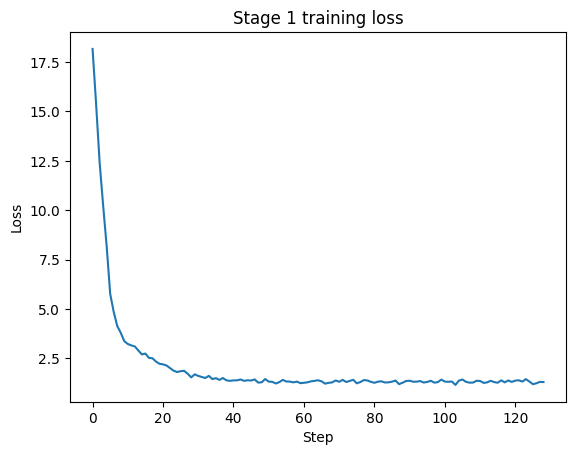

In [9]:
losses = [h['loss'] for h in history1 if 'loss' in h]
plt.plot(losses)
plt.title('Stage 1 training loss'); plt.xlabel('Step'); plt.ylabel('Loss')
plt.show()

## ✏️ Stage 2 – Domain fine‑tune

In [11]:

dom_train, dom_val = prep_dataset(
    DOMAIN_PATH,
    source_col='text',
    target_col='summary',
    split_ratio=0.9,     # 90 % train
    limit=None           # full data
)

history2 = train_stage(dom_train, dom_val, OUTPUT_DIR/'stage2', num_epochs=1)

stage2_scores = evaluate_model(
    model,
    dom_val
)

/tmp/ipykernel_35/476166026.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(model, args, train_dataset=train_ds, eval_dataset=val_ds,
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,0.218500
20,0.192800
30,0.170300
40,0.146900
50,0.150400
60,0.131500
70,0.134800
80,0.113500
90,0.100400
100,0.100700


ROUGE‑L: 0.6011 | BERTScore‑F1: 0.9527


### 📈 Stage 2 loss curve

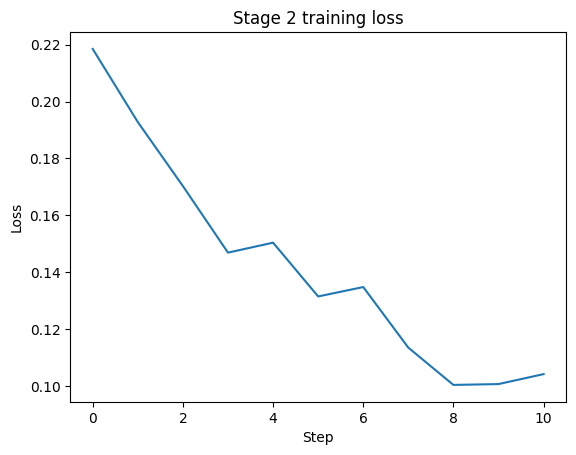

In [12]:
losses2 = [h['loss'] for h in history2 if 'loss' in h]
plt.plot(losses2)
plt.title('Stage 2 training loss'); plt.xlabel('Step'); plt.ylabel('Loss')
plt.show()

### 🔬 Results summary

In [13]:
import pandas as pd
import numpy as np

df = pd.DataFrame([
    {'stage': 'baseline', 'rougeL': baseline_scores[0], 'bertscore_f1': baseline_scores[1]},
    {'stage': 'post-CNN', 'rougeL': stage1_scores[0], 'bertscore_f1': stage1_scores[1]},
    {'stage': 'final',    'rougeL': stage2_scores[0], 'bertscore_f1': stage2_scores[1]},
]).set_index('stage')

# Replace NaN ROUGE with a dash for readability
df['rougeL'] = df['rougeL'].apply(lambda x: '—' if (isinstance(x, float) and np.isnan(x)) else x)

df


,rougeL,bertscore_f1
stage,,
baseline,0.249057,0.866347
post-CNN,0.266905,0.873574
final,0.601080,0.952734
